In [2]:
%matplotlib inline

# Step 1: Import Object

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
from uncertainties import unumpy as unp
import numpy as np
import uncertainties as unc
import copy

from sys import path
path.append('../')
path.append('../pylib/')
path.append('../../../seaquest-distribution/seaquest_scripts/pylib/')
from emc import *
from keff import kEffCorrection
import targets

%autoreload 2
%aimport emc

ERROR: Line magic function `%autoreload` not found.
ERROR: Line magic function `%aimport` not found.


In [4]:
targets.target_df

,TargetPos,Density[g/cm^3],Length[cm],LengthPerLayer[cm],NLayers,NIL[g/cm^2],NIL/D[cm],MassNo[g/mol],Density[/cm^3],Density[mol/cm^3],IntLengths,AttenLength[cm],Scale
targetPos,,,,,,,,,,,,,
LH2,1,0.0708,50.80000,50.80000,1,52.0,734.463277,1.00794,4.230089e+22,0.070242,0.069166,49.082993,3.475076
Empty,2,NaN,50.80000,50.80000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LD2,3,0.1634,50.80000,50.80000,1,71.8,439.412485,2.01410,4.885646e+22,0.081128,0.115609,47.973498,7.838870
None,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fe,5,7.8740,1.90500,0.63500,3,132.1,16.776734,55.84500,8.491063e+22,0.140997,0.113550,1.800824,14.179685
C,6,1.8020,3.32232,1.10744,3,85.8,47.613762,12.01070,9.035192e+22,0.150033,0.069776,3.209060,5.782726
W,7,19.3000,0.95250,0.31750,3,191.9,9.943005,183.84000,6.322200e+22,0.104983,0.095796,0.908300,17.530185


In [6]:
targets.target_df.ix[2:][['TargetPos', 'Length[cm]', 'Density[g/cm^3]', 'NIL[g/cm^2]', 'NIL/D[cm]', 'AttenLength[cm]']]

,TargetPos,Length[cm],Density[g/cm^3],NIL[g/cm^2],NIL/D[cm],AttenLength[cm]
targetPos,,,,,,
LD2,3,50.80000,0.1634,71.8,439.412485,47.973498
None,4,NaN,NaN,NaN,NaN,NaN
Fe,5,1.90500,7.8740,132.1,16.776734,1.800824
C,6,3.32232,1.8020,85.8,47.613762,3.209060
W,7,0.95250,19.3000,191.9,9.943005,0.908300


In [12]:
targets.target_df['xi'] = (targets.target_df['Length[cm]']/targets.target_df['NIL/D[cm]'])

In [15]:
targets.target_df['Density[/cm^3]']/6.0221409e+23

targetPos
LH2      0.070242
Empty         NaN
LD2      0.081128
None          NaN
Fe       0.140997
C        0.150033
W        0.104983
Name: Density[/cm^3], dtype: float64

In [13]:
(1.0 - np.exp(-1.0*targets.target_df.xi))/targets.target_df.xi

targetPos
LH2      0.966201
Empty         NaN
LD2      0.944360
None          NaN
Fe       0.945314
C        0.965909
W        0.953596
Name: xi, dtype: float64

In [4]:
h_len = 50.8
h_nil = 734.463
d_len = 50.8
d_nil = 439.412
x_h = 1.0 - np.exp(h_len/h_nil)
x_d = 1.0 - np.exp(d_len/d_nil)

In [5]:
%%time
c1 = kEffCorrection(roadset=67, targetPos=1, mass_range=(4.2, 10),
                    intensity=[5000*i for i in range(0,21)])
c3 = kEffCorrection(roadset=67, targetPos=3, mass_range=(4.2, 10),
                    intensity=[5000*i for i in range(0,21)])

CPU times: user 11.1 s, sys: 1.56 s, total: 12.6 s
Wall time: 16.1 s


In [6]:
c2 = copy.copy(c3)
c2.exp_df.p0 = c1.exp_df.p0 - x_h*(c3.exp_df.p0 - c1.exp_df.p0)/(x_d - x_h)

In [7]:
server = 'e906-db3.fnal.gov'
analysis_schema = 'user_dannowitz_analysis_april2016'
analysis_table = 'kDimuon'
merged_schema_list = [#'merged_roadset57_R005_V001',
                      'merged_roadset59_R005_V001']#,
                      #'merged_roadset62_R005_V001',
                      #'merged_roadset67_R005_V001']
# If fresh start == True, re-apply all cuts (takes ~10min)
#fresh_start = False
fresh_start = True

In [8]:
# Get valid target dimuons
dimuon_df = get_dimuon_df(server=server, 
                          analysis_schema=analysis_schema, 
                          source_schema_list=merged_schema_list,
                          analysis_table=analysis_table,
                          fresh_start=fresh_start)

>>> Retrieving and Cleaning Dimuon Data for merged_roadset59_R005_V001
2291346 dimuons from source table.
346224 entries copied over with mass between 4.200000 and 10.000000 GeV and chisq<15.000000
344068 dimuons: after 2156 entries deleted for x-range cuts
16284 dimuons: after 327784 entries deleted for dimuon-level cuts
11090 dimuons: after 5194 entries deleted for bad spill cuts
3039 dimuons: after 8051 entries deleted for track-level cuts
1637 dimuons: after 1402 entries deleted for dump-radius cut
1626 dimuons: after 11 entries deleted for event level cuts
1625 dimuons: after 1 entries deleted for kEvent status cut
Adding QIE information to Dimuon table.
Adding chamber_intensity information to Dimuon table.
1625 dimuons after all cuts


In [9]:
dimuon_df.head()

,dimuonID,runID,spillID,eventID,targetPos,posTrackID,negTrackID,dx,dy,dz,...,QIESum,chamber_intensity,trigger_intensity,weight,dpt,pt1,pt2,target,roadset,weight_sq
0,855,10587,376657,15673,1,9201,9200,0.103993,-0.179449,-67.042000,...,62376000000,50499.4,47763.1,None,1.288050,2.021651,2.614423,LH2,59,NaN
1,1345,10587,376659,24996,1,14727,14729,0.284441,0.221404,-80.111519,...,62643600000,18506.8,24374.3,None,2.700807,1.661038,4.014203,LH2,59,NaN
2,2748,10587,376666,52769,7,31020,31019,-0.394467,-0.194530,-150.105188,...,63501900000,38912.7,70001.8,None,0.419545,2.360573,2.136640,W,59,NaN
3,2764,10587,376666,52950,7,31140,31139,-0.233087,0.235508,-135.192123,...,63501900000,25838.3,17898.6,None,1.012635,1.932313,2.054595,W,59,NaN
4,4460,10778,382853,111865,6,62696,62697,0.449465,0.247646,-185.391556,...,74485600000,40492.9,107287.0,None,1.360305,2.577327,1.570090,C,59,NaN


In [18]:
empty_df = dimuon_df.query('targetPos==2').copy()
empty_df['weight'] = c2.kEff(empty_df[['xT', 'Intensity_p']], inv=True)

(array([ 114.93240962,  295.76883517,  368.09843342,  282.37445467,
         221.62235556,  114.06975422]),
 array([    0, 10000, 20000, 30000, 40000, 50000, 60000]),
 <a list of 6 Patch objects>)

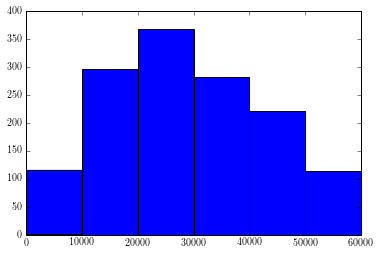

In [20]:
plt.hist(empty_df.Intensity_p, 
         bins=[0,10000,20000,30000,40000,50000,60000], 
         weights=empty_df.weight)

In [9]:
def exp_func(x, c):
    return np.exp(-c*x)

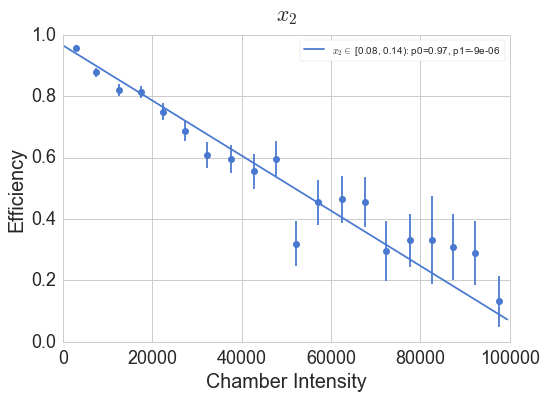

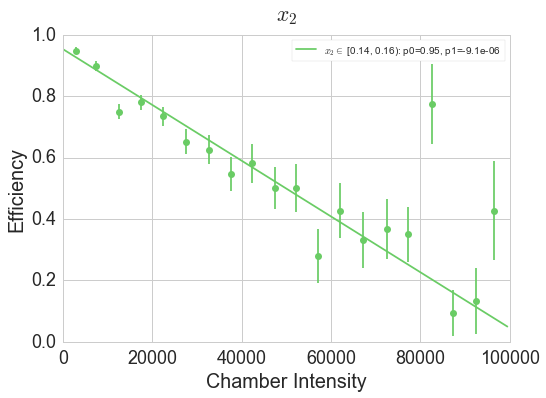

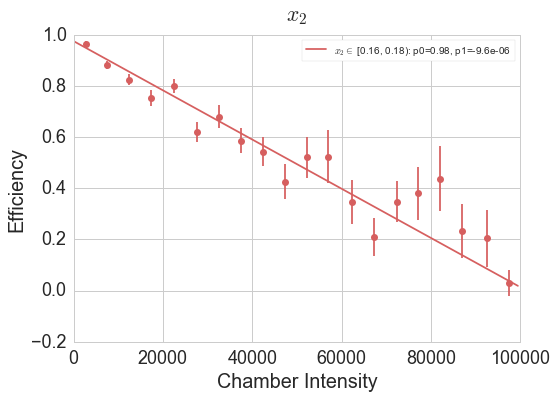

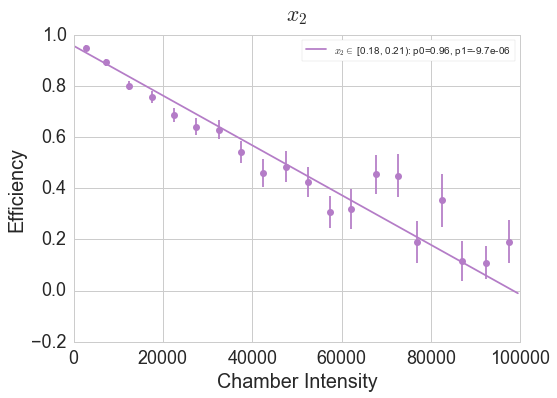

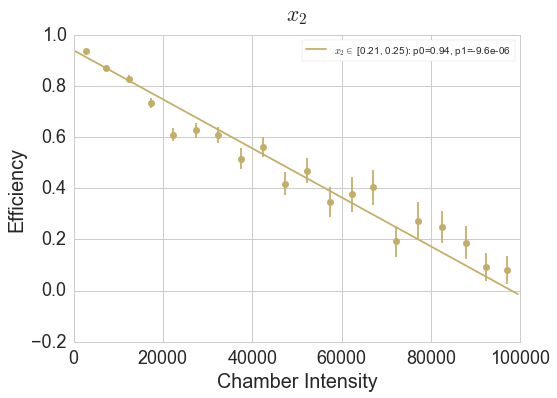

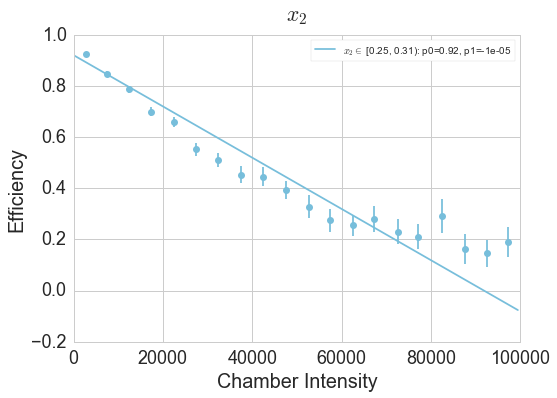

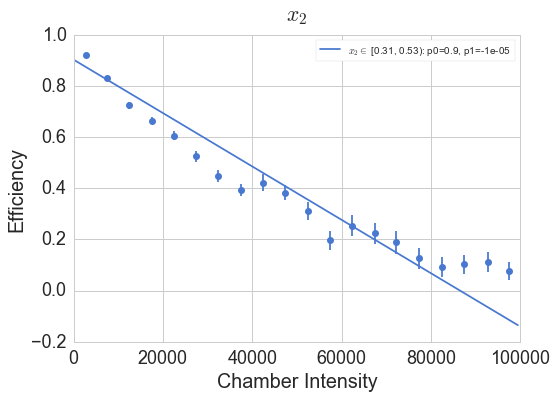

In [27]:
n = len(c1.lin_df)
pal = sns.color_palette("muted", n)
i = 0

for index, row in c1.lin_df.iterrows():
    eff = c1.eff_df.ix[index].efficiency.values
    unc = c1.eff_df.ix[index].uncertainty.values
    intensity = c1.eff_df.ix[index].w_mean_intensity.values
    min_int = 0
    max_int = max(c1.intensity)
    
    x = np.arange(min_int, max_int, 500)
    ax = plt.errorbar(intensity, eff, yerr=unc, fmt='o', color=pal[i])
    plt.plot(x, lin_func(x, row.p0, row.p1),
             label=(r'$x_2\in$ %s: p0=%.2g, p1=%.2g' % (index, row.p0, row.p1)),
             color=pal[i])
    #         color=pal[4])
    #plt.fill_between(*get_confidence(intensity, eff, row.p0, row.p1), alpha=0.3, color=pal[i])
                     #color=pal[3], alpha=0.3, label='95% confidence')
    i += 1
    
    plt.legend(loc='best', frameon=True, fontsize=10)
    plt.title(r'$x_2$', y=1.03)
    plt.ylabel('Efficiency')
    plt.xlabel('Chamber Intensity')
    plt.show()

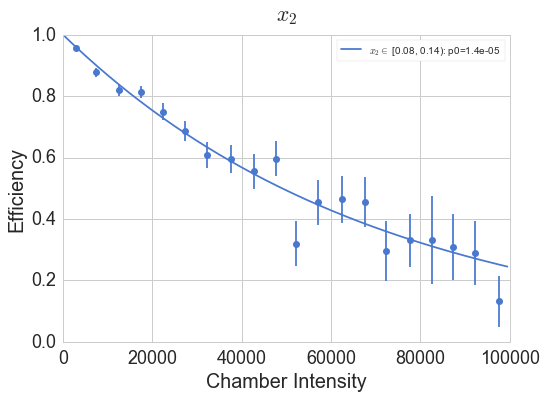

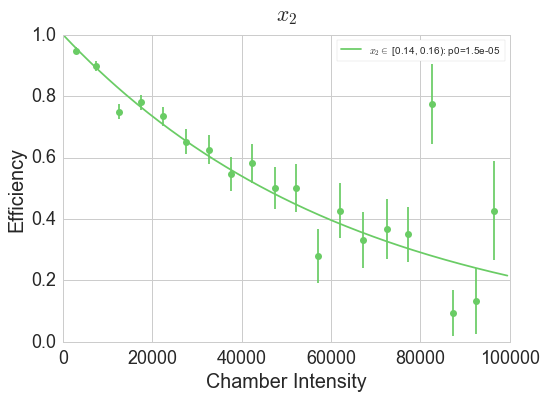

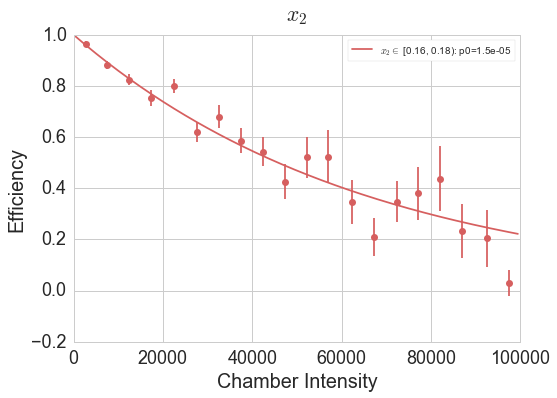

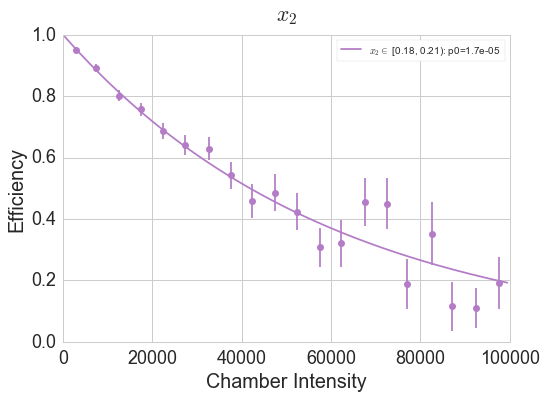

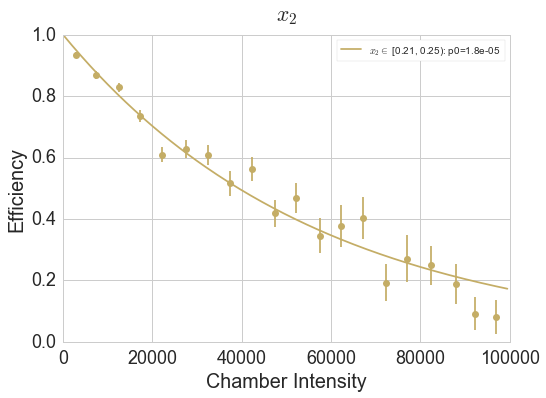

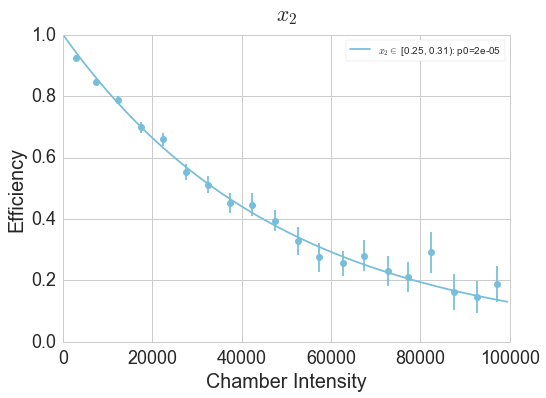

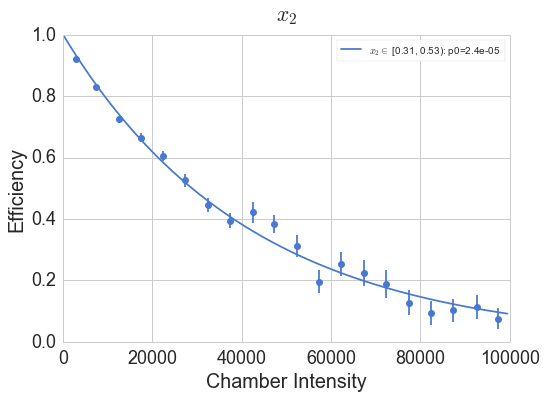

In [28]:
n = len(c1.exp_df)
pal = sns.color_palette("muted", n)
i = 0

for index, row in c1.exp_df.iterrows():
    eff = c1.eff_df.ix[index].efficiency.values
    unc = c1.eff_df.ix[index].uncertainty.values
    intensity = c1.eff_df.ix[index].w_mean_intensity.values
    min_int = 0
    max_int = max(c1.intensity)
    
    x = np.arange(min_int, max_int, 500)
    ax = plt.errorbar(intensity, eff, yerr=unc, fmt='o', color=pal[i])
    plt.plot(x, exp_func(x, row.p0),
             label=(r'$x_2\in$ %s: p0=%.2g' % (index, row.p0)),
             color=pal[i])
    #         color=pal[4])
    #plt.fill_between(*get_confidence(intensity, eff, row.p0, row.p1), alpha=0.3, color=pal[i])
                     #color=pal[3], alpha=0.3, label='95% confidence')
    i += 1
    
    plt.legend(loc='best', frameon=True, fontsize=10)
    plt.title(r'$x_2$', y=1.03)
    plt.ylabel('Efficiency')
    plt.xlabel('Chamber Intensity')
    plt.show()

In [9]:
print exp_func(65000, 1.048538, 0.000018)
print exp_func(30001, 1.048538, 0.000018)
print exp_func(13500, 1.048538, 0.000018)
print exp_func(45000, 1.048538, 0.000018)

0.32543153186062912

In [10]:
c1.kEff(data)#, inv=True, ret_unc=True)

array([ 0.77622996,  0.68304932,  0.84444022,  0.32630371])

### Options:

* Evan instructs to use 1/kEff() as weight, so can use the 'inv' option to invert
* Uncertainties in weights available with 'unc' option

In [20]:
c1.kEff(data, inv=True)

array([ 1.29877445,  1.52150403,  1.17645684,  4.04463401])

In [21]:
c1.kEff(data, unc=True)

array([[ 0.76995663,  0.01183683],
       [ 0.6572444 ,  0.01593581],
       [ 0.85000994,  0.01606521],
       [ 0.24724116,  0.02747901]])

In [22]:
c1.kEff(data, unc=True, inv=True)

array([[ 1.29877445,  0.01996655],
       [ 1.52150403,  0.03689101],
       [ 1.17645684,  0.02223506],
       [ 4.04463401,  0.44953084]])

# Step 4: Weight your dimuons with these values!

-----

-----

## Status:

* **Not ready yet**: cross checking with Evan
* These weights used in BZ's empty/none correction, more development coming soon

-----

-----

# ANOTHER EXAMPLE

* Bin in many kinematic bins

In [10]:
kin_bins = {'xT': [0.08, 0.14, 0.16, 0.18, 0.21, 0.25, 0.31, 0.53],
            'xB': [0.1, 0.7, 0.8, 1.0]}

In [11]:
from collections import OrderedDict
ord_kin_bin = OrderedDict(kin_bins)

In [12]:
for kin in kin_bins:
    print kin
    
for kin in ord_kin_bin:
    print kin

xB
xT
xB
xT


In [48]:
c2 = kEffCorrection(67, 3, mass_range=(4.2,300), kinematics=kin_bins)

In [49]:
c2.eff_df[['efficiency', 'uncertainty']].head(14)

efficiency  uncertainty
xB         xT           chamber_intensity                         
(0.1, 0.7] (0.08, 0.14] (0, 10000]           0.972708     0.001761
                        (10000, 20000]       0.853883     0.004211
                        (20000, 30000]       0.775112     0.005258
                        (30000, 40000]       0.651956     0.007381
                        (40000, 50000]       0.644612     0.007259
                        (50000, 60000]       0.522200     0.008915
                        (60000, 70000]       0.549951     0.010099
           (0.14, 0.16] (0, 10000]           0.953893     0.001756
                        (10000, 20000]       0.792406     0.003686
                        (20000, 30000]       0.746571     0.004528
                        (30000, 40000]       0.653391     0.005339
                        (40000, 50000]       0.660796     0.006303
                        (50000, 60000]       0.396870     0.006630
                        (60000, 70000]       0.399299     0.008174

In [50]:
c2.lin_df

p0    p0_unc        p1        p1_unc
xB         xT                                                      
(0.1, 0.7] (0.08, 0.14]  1.008650  0.013232 -0.000009  6.724690e-07
           (0.14, 0.16]  0.992255  0.021053 -0.000010  9.267099e-07
           (0.16, 0.18]  1.005977  0.021431 -0.000010  9.781135e-07
           (0.18, 0.21]  0.993592  0.011605 -0.000010  5.129422e-07
           (0.21, 0.25]  0.969155  0.015916 -0.000009  6.749190e-07
           (0.25, 0.31]  0.979412  0.011108 -0.000012  4.306220e-07
           (0.31, 0.53]  0.956372  0.019563 -0.000012  7.246148e-07
(0.7, 0.8] (0.08, 0.14]  0.990745  0.017473 -0.000007  7.753071e-07
           (0.14, 0.16]  1.032664  0.009992 -0.000009  6.478731e-07
           (0.16, 0.18]  1.022619  0.021378 -0.000008  1.183227e-06
           (0.18, 0.21]  1.008452  0.012326 -0.000008  6.052777e-07
           (0.21, 0.25]  1.014293  0.013685 -0.000009  6.926723e-07
           (0.25, 0.31]  1.005997  0.010761 -0.000008  5.071561e-07
           (0.31, 0.53]  1.045795  0.004538 -0.000011  3.448227e-07
(0.8, 1]   (0.08, 0.14]  0.996630  0.021082 -0.000005  9.790291e-07
           (0.14, 0.16]  1.012093  0.018733 -0.000008  8.984862e-07
           (0.16, 0.18]  1.016081  0.011332 -0.000008  5.851631e-07
           (0.18, 0.21]  1.019491  0.019261 -0.000008  9.671962e-07
           (0.21, 0.25]  1.037087  0.022495 -0.000009  1.199576e-06
           (0.25, 0.31]  1.025811  0.010488 -0.000008  6.301991e-07
           (0.31, 0.53]  1.042554  0.009063 -0.000009  7.068654e-07

In [51]:
data = [[0.63, 0.12, 65000],
        [0.54, 0.2, 30001],
        [0.8, 0.17, 5000]]

In [53]:
c2.kEff(data, inv=True)

array([ 2.20442356,  1.43786969,  1.01607714])

(0.08, 0.14]: p0 = 1.028 +/- 0.0154; p1 = -9.093e-06 +/- 1.41e-06
(0.14, 0.16]: p0 = 1.019 +/- 0.01468; p1 = -8.366e-06 +/- 1.349e-06
(0.16, 0.18]: p0 = 1.018 +/- 0.01253; p1 = -9.961e-06 +/- 9.315e-07
(0.18, 0.21]: p0 = 1.017 +/- 0.0122; p1 = -7.925e-06 +/- 1.073e-06
(0.21, 0.25]: p0 = 0.9794 +/- 0.01084; p1 = -8.295e-06 +/- 7.007e-07
(0.25, 0.31]: p0 = 0.9839 +/- 0.0104; p1 = -9.439e-06 +/- 6.601e-07
(0.31, 0.53]: p0 = 1.001 +/- 0.01105; p1 = -1.209e-05 +/- 7.266e-07


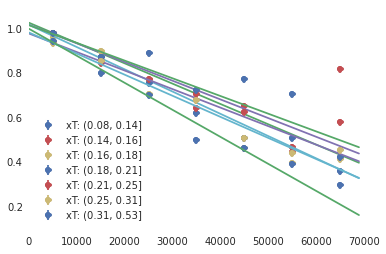

In [165]:
for kin_bin in eff.index.levels[0].values:
    popt, pcov = curve_fit(linear, intensity_centers, eff[kin_bin].values, sigma=eff_unc[kin_bin])
    print ("%s: p0 = %.4g +/- %.4g; p1 = %.4g +/- %.4g" %
           (kin_bin, popt[0], pcov[0,0]**0.5, popt[1], pcov[1,1]**0.5))
    ax = plt.errorbar(intensity_centers, eff[kin_bin].values,
                      yerr=eff_unc[kin_bin].values, fmt='o',
                      label=("%s: %s" % (eff.index.names[0], kin_bin)))
    plt.plot(x, linear(x,popt[0], popt[1]))
    #ax = eff[kin_bin].plot()
#plt.set_xticklabels(intensity_centers)
plt.legend(loc='best')